In [2]:
import numpy as np
import pandas as pd
from scipy.fftpack import fft, ifft
from scipy.stats import norm

import matplotlib.pyplot as plt

In [3]:

def efficient_sim_GaussianVector(m,mu,c):
    n=c.size-1
    gamma=np.zeros(2*n)
    gamma[:n+1]=c
    gamma[n+1:]=np.flip(c[1:-1])
    lambd=fft(gamma)

    if np.any(lambd < 0):
        raise ValueError("The covariance function is not positive definite.")

    res=[]
    for i in range(m):
        Z=ifft(norm.rvs(size=2*n))
        X=fft(np.dot(np.diag(np.sqrt(lambd)),Z))
        res.append(X[:n]+mu)
    return res

def sim_fBm(H,n,delta,m):
    c=np.array([0.5*(abs(k+1)**(2*H)+abs(k-1)**(2*H))-abs(k)**(2*H) for k in range(n+1)])
    mu=np.zeros(n)
    dX=efficient_sim_GaussianVector(m,mu,c)
    res=[]
    for k in range(m):
        vect=[]
        for j in range(n):
            vect.append(dX[k][:j])
            res.append((delta**H)*np.sum(vect[j]))
    #delete imaginary part since they all equal 0.
    eps = 1e-10
    res=np.array(res, dtype=complex)
    all_reals = np.all(abs(res.imag) < eps)
    if all_reals:
        res=res.real
    else:
        print("Error")
    return res


<Figure size 1500x900 with 0 Axes>

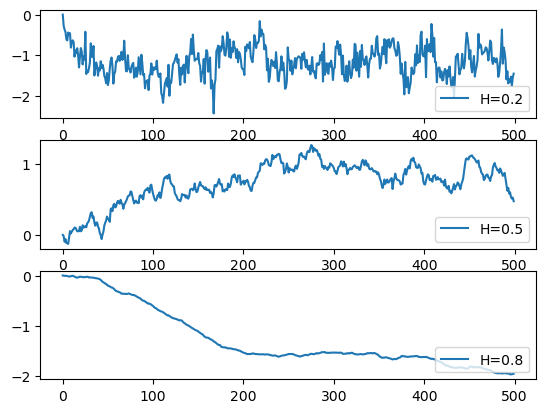

<Figure size 1500x900 with 0 Axes>

In [4]:

plt.figure()

n=500
delta=1/n
H=[0.2,0.5,0.8]
m=1
for i in range(3):
    W=sim_fBm(H[i],n,delta,m)
    plt.subplot(3,1,i+1)
    plt.plot(W,label="H={}".format(H[i]))
    plt.legend(loc='lower right')

plt.figure(figsize=(15,9))

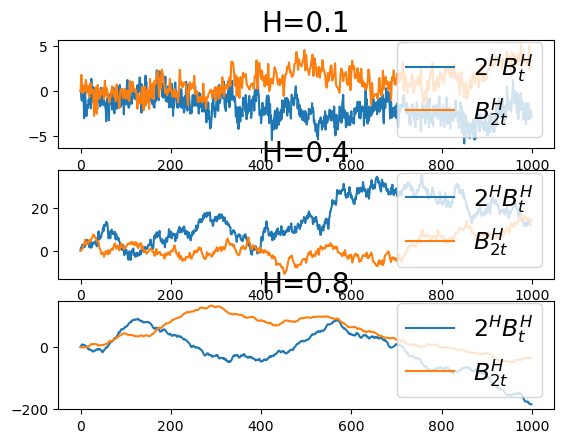

In [6]:
H=[0.1,0.4,0.8]
x=np.linspace(0,999,1000)
index=np.arange(0,999,2)
for i in range(3):
    W1=(2**H[i])*sim_fBm(H[i],1000,1,1)
    W2=sim_fBm(H[i],500,2,1)
    plt.subplot(3,1,i+1)
    plt.plot(x,W1,label="$2^H B_t^H$")
    plt.plot(index,W2,label="$B_{2t}^H$")
    plt.title("H={}".format(H[i]), fontsize=20)
    plt.legend(loc="lower right", fontsize=17)

In [7]:

def sim_fOU(H,n,delta,mu,nu,alpha,X0):
    
    # H the Hurst parameter
    # n the number of steps
    # delta the step size
    # mu the mean
    # nu the noise
    # alpha the reversion spead
    # X0 the initial value
    
    W=sim_fBm(H,n,delta,1)
    X=[X0]
    for step in range(1,n):
        X.append(X[step-1]+nu*(W[step]-W[step-1])+alpha*delta*(mu-X[step-1]))
    return X

n=3540
delta=1
H=0.14
mu=-5
nu=0.3
alpha=5E-4
X0=-5

logvol=sim_fOU(H,n,delta,mu,nu,alpha,X0)
logvol=pd.Series(data=logvol)

def hurst_est(q, x, data): 
    return [np.mean(np.abs(data - data.shift(lag))**q) for lag in x]

[0.07457830580933134, 0.14787843110127488, 0.22000893938261207, 0.2911614778595801, 0.4316086512030727]


<Figure size 640x480 with 0 Axes>

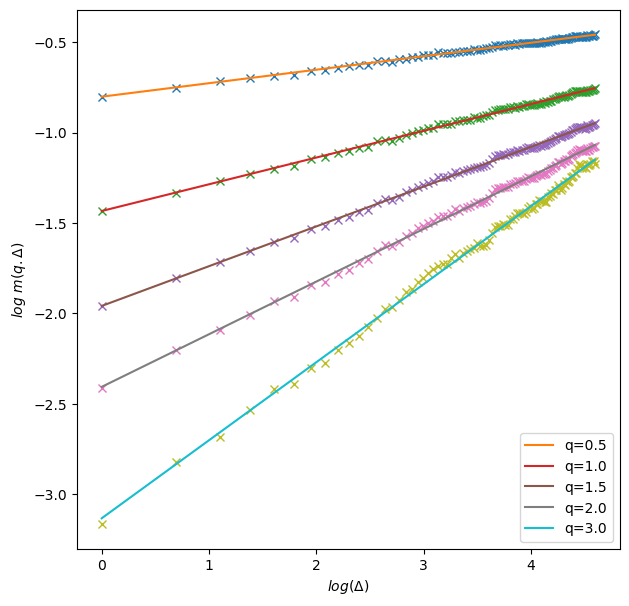

<Figure size 640x480 with 0 Axes>

In [8]:

plt.figure(figsize=(7, 7))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = []
Q = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in Q:
    plt.plot(np.log(x), np.log(hurst_est(q, x,logvol)), 'x') 
    model = np.polyfit(np.log(x), np.log(hurst_est(q, x, logvol)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1], label="q={}".format(q))
    plt.legend(loc='lower right')
    zeta_q.append(model[0]) 
print(zeta_q)


plt.figure()


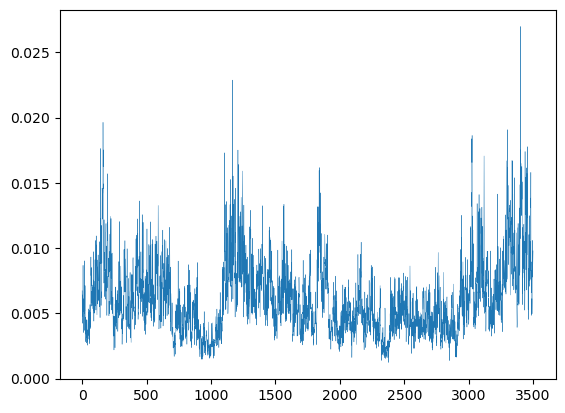

In [9]:
# 3500 days, 1 data per day
n=3500
delta=1
H=0.14
mu=-5
nu=0.3
alpha=5E-4
X0=-5
logvol=sim_fOU(H,n,delta,mu,nu,alpha,X0)
logvol=pd.Series(data=logvol)
plt.plot(logvol.apply(np.exp),linewidth=0.3)